In [53]:
import matplotlib.pyplot as plt
import torch
import cv2
import random
from torchvision import transforms
import numpy as np
from easydict import EasyDict
from utils.datasets import letterbox
from utils.general import non_max_suppression, scale_coords, xyxy2xywh
from utils.plots import plot_one_box
from models.experimental import attempt_load

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights = './runs/train/yolov7-w6-2303-all/weights/best.pt'
model = attempt_load(weights, map_location=device)
_ = model.eval()

Fusing layers... 
IAuxDetect.fuse


In [59]:
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
names, colors

(['ycrane', 'forklift', 'wcrane', 'car', 'crane arm'],
 [[60, 234, 125], [23, 206, 15], [204, 25, 6], [36, 23, 46], [213, 243, 120]])

In [68]:
opt = EasyDict()
# 参照 detect.py 的默认值
opt.conf_thres = 0.25
opt.iou_thres = 0.45
opt.classes = None
opt.agnostic_nms = True # class-agnostic NMS
opt.save_conf = True

save_txt = False
save_img = True
view_img = True

这里就定mini-batch大小为1了

In [133]:
im0 = cv2.imread('./inference/guangzhou-2303/P23031014583810.jpg')  # 1920*2560
img_show = im0.copy()     # 可视化bbox用
img = letterbox(im0, 1280, stride=64, auto=True)[0]
img_ = img.copy()
img = transforms.ToTensor()(img_)
img = torch.tensor(np.array([img.numpy()]))
img = img.to(device)
# image = image.half()

pred = model(img)[0]

In [134]:
pred_nms = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
pred_nms

[tensor([[773.32825, 345.85855, 965.41064, 717.85925,   0.98154,   0.00000],
         [654.47241, 171.93806, 678.51331, 202.42183,   0.98129,   3.00000],
         [717.52429, 285.36929, 744.85181, 310.61130,   0.98040,   3.00000],
         [857.06702, 344.93488, 938.37878, 601.73035,   0.97771,   4.00000],
         [632.37415, 185.12724, 653.43909, 201.88200,   0.96977,   3.00000],
         [691.10193, 246.03955, 711.17285, 318.20917,   0.96572,   1.00000],
         [663.86469, 204.04886, 687.71698, 224.88776,   0.96571,   3.00000]], device='cuda:0')]

In [135]:
for i, det in enumerate(pred_nms):  # detections per image, 实际上只有一张图
    save_path = './inference/guangzhou-2303/output.jpg'
    txt_path = './inference/guangzhou-2303/output.txt'
    gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    s = ''  # 输出字串
    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape[:2]).round()
        # Print results
        for c in det[:, -1].unique():
            n = (det[:, -1] == c).sum()  # detections per class
            s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
        # Write results
        for *xyxy, conf, cls in reversed(det):
            xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
            if int(cls) != 4:
                # 不是吊臂，则输出bbox下边缘中点
                print([float((xyxy[0]+xyxy[2])/2), float(xyxy[3])])
            else:
                # 是吊臂，则
                crane_arm = im0[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]
                print()
            if save_txt:  # Write to file
                line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                with open(txt_path + '.txt', 'a') as f:
                    f.write(('%g ' * len(line)).rstrip() % line + '\n')
            if save_img or view_img:  # Add bbox to image
                label = f'{names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, img_show, label=label, color=colors[int(cls)], line_thickness=1)
    print(s)
    cv2.imwrite(save_path, img_show)

[1351.5, 450.0]
[1402.0, 636.0]
[1286.0, 404.0]

[1462.5, 621.0]
[1333.0, 405.0]
[1739.0, 1436.0]
1 ycrane, 1 forklift, 4 cars, 1 crane arm, 


In [136]:
%matplotlib inline
from matplotlib import pyplot as plt

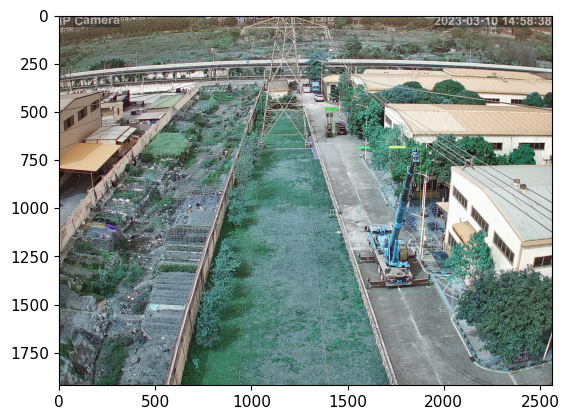

In [139]:
plt.imshow(img_show) # RGB和BGR是反的，转一下就行，保存下来是正常的

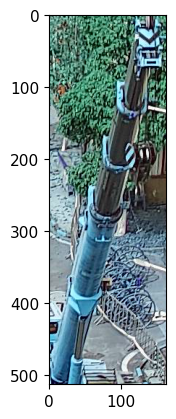

In [140]:
plt.imshow(crane_arm)

In [142]:
tmp = cv2.Canny(crane_arm, 240, 255)
lines = cv2.HoughLinesP(tmp, 1.0, np.pi/180, 200, minLineLength=50, maxLineGap=5)

In [143]:
lines

array([[[ 47, 456,  63, 395]],

       [[ 98, 364, 112, 418]]], dtype=int32)

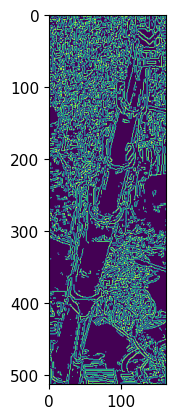

In [144]:
plt.imshow(tmp)

效果太差了，试试截取背景分割的结果

In [168]:
im0 = cv2.imread('./inference/guangzhou-2303/P23031014583810.jpg')  # 1920*2560
im_background = cv2.imread('./inference/guangzhou-2303/P23031017142610.jpg')
img_show = im0.copy()     # 可视化bbox用
img = letterbox(im0, 1280, stride=64, auto=True)[0]
img_ = img.copy()
img = transforms.ToTensor()(img_)
img = torch.tensor(np.array([img.numpy()]))
img = img.to(device)
# image = image.half()

pred = model(img)[0]
pred_nms = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)

for i, det in enumerate(pred_nms):  # detections per image, 实际上只有一张图
    save_path = './inference/guangzhou-2303/output.jpg'
    txt_path = './inference/guangzhou-2303/output.txt'
    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()   # 背景差分
    _ = fgbg.apply(im_background)
    fgbgmask = fgbg.apply(im0)
    # im0_mask = np.empty_like(im0)
    # im0_mask[:,:,0] = fgbgmask
    # im0_mask[:,:,1] = fgbgmask
    # im0_mask[:,:,2] = fgbgmask
    print(im0_mask.shape)
    gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    s = ''  # 输出字串
    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape[:2]).round()
        # Print results
        for c in det[:, -1].unique():
            n = (det[:, -1] == c).sum()  # detections per class
            s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
        # Write results
        for *xyxy, conf, cls in reversed(det):
            xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
            if int(cls) != 4:
                # 不是吊臂，则输出bbox下边缘中点
                print([float((xyxy[0]+xyxy[2])/2), float(xyxy[3])])
            else:
                # 是吊臂，则截取mask的吊臂部分，做霍夫变换检测线段，根据线段方向投票判断朝向
                crane_arm = fgbgmask[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]
                lines = cv2.HoughLinesP(crane_arm, 1.0, np.pi/180, 200, minLineLength=50, maxLineGap=5)
                cnt1 = 0    # 向左上右下
                cnt2 = 0    # 向左下右上
                for line in lines:
                    x1, y1, x2, y2 = line.reshape(4)
                    if (x1-x2)*(y1-y2) > 0:
                        cnt1 += 1
                    else:
                        cnt2 += 1
                # 输出 [吊臂顶端点, 吊臂底端点]
                if cnt1 > cnt2:
                    # 向左上右下
                    print([float(xyxy[0]),float(xyxy[1]),float(xyxy[2]),float(xyxy[3])])
                else:
                    # 向左下右上
                    print([float(xyxy[2]),float(xyxy[1]),float(xyxy[0]),float(xyxy[3])])
            if save_txt:  # Write to file
                line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                with open(txt_path + '.txt', 'a') as f:
                    f.write(('%g ' * len(line)).rstrip() % line + '\n')
            if save_img or view_img:  # Add bbox to image
                label = f'{names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, img_show, label=label, color=colors[int(cls)], line_thickness=1)
    print(s)
    cv2.imwrite(save_path, img_show)

(1920, 2560, 3)
[1351.5, 450.0]
[1402.0, 636.0]
[1286.0, 404.0]
[1877.0, 690.0, 1714.0, 1203.0]
[1462.5, 621.0]
[1333.0, 405.0]
[1739.0, 1436.0]
1 ycrane, 1 forklift, 4 cars, 1 crane arm, 


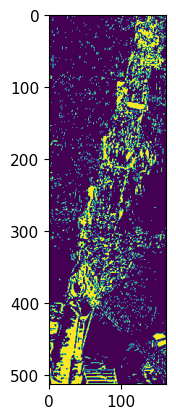

In [156]:
plt.imshow(crane_arm)

In [163]:
# tmp = cv2.Canny(crane_arm, 240, 255)
lines = cv2.HoughLinesP(crane_arm, 1.0, np.pi/180, 200, minLineLength=50, maxLineGap=5)
lines.shape

(28, 1, 4)

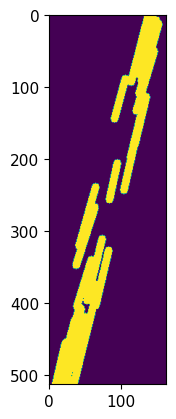

In [162]:
tmp = np.zeros_like(crane_arm)
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    cv2.line(tmp, (x1,y1), (x2,y2),255,10)
plt.imshow(tmp)